In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from scipy.stats import randint

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [ ]:
# Load dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [3]:
# Manual feature selection: use only alternative features (no price indicators)

selected_features = [
  'news_count',
  'tanalysis_absa', 'economy_absa', 'regulation_absa', 
  'adoption_absa', 'cybersecurity_absa', 'technology_absa',
  'tanalysis_absa_ewm_100h', 'economy_absa_ewm_100h',
  'regulation_absa_ewm_100h', 'technology_absa_ewm_100h',
  'adoption_absa_ewm_100h', 'cybersecurity_absa_ewm_100h',

  'reddit_total_sentiment_ewm_2h',
  'reddit_average_sentiment_ewm_100h',

  'topic_exchange traded funds, ETF_last3',
  'topic_institutional investments_last3',
  'topic_market sentiment_last3',
  'topic_price action, price movement, trading_last3',

  "source_Coindesk_last3",  
  "source_Cointelegraph_last3",  
  "source_Bitcoin Magazine_last3",  
  "source_Benzinga_last3",  
  "source_The Daily Hodl_last3",  

  "NER_blackrock_last3",  
  "NER_sec_last3",  
  "NER_fed_last3",  
  "NER_grayscale_last3",  
  "NER_binance_last3",  
  "NER_coinbase_last3",  
  "NER_microstrategy_last3",  
  "NER_michael saylor_last3"  
]

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[selected_features]
y_train = df_train['target']
X_test = df_test[selected_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

X_train shape: (26274, 32)
y_train shape: (26274,)
X_test shape: (8784, 32)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### RandomForestClassifier Model with RandomizedSearchCV

In [ ]:
# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample', # Good for imbalanced data with RF
    n_jobs=-1 # Use all cores for fitting individual trees
  ))
])

# Parameter distribution for RandomizedSearchCV
param_dist = {
  'model__n_estimators': randint(50, 300),
  'model__max_depth': randint(10, 30),
  'model__min_samples_split': randint(2, 10),
  'model__min_samples_leaf': randint(1, 6),
  'model__max_features': ['sqrt', 'log2', None]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomizedSearchCV
n_iterations = 100 # Number of parameter settings to sample
random_search = RandomizedSearchCV(
  estimator=pipeline,
  param_distributions=param_dist,
  n_iter=n_iterations,
  cv=tscv,
  scoring='roc_auc_ovr', # Use One-vs-Rest ROC AUC for multiclass
  n_jobs=3,
  verbose=1,
  random_state=42 # For reproducibility of the search
)

# Fit RandomizedSearchCV on the training data
print(f"Starting RandomizedSearchCV for RandomForestClassifier ({n_iterations} iterations)...")
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nRandomizedSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation ROC AUC score: ", random_search.best_score_)

# Get the best estimator found by RandomizedSearchCV
best_model = random_search.best_estimator_

Starting RandomizedSearchCV for RandomForestClassifier (200 iterations)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

RandomizedSearchCV fitting time: 1888.56 seconds
Best parameters found:  {'model__max_depth': 13, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 9, 'model__n_estimators': 197}
Best cross-validation ROC AUC score:  0.5220117483157404


### Feature Importance Analysis


Top 20 most important features:
                              Feature  Importance
14  reddit_average_sentiment_ewm_100h    0.095398
9            regulation_absa_ewm_100h    0.089514
11             adoption_absa_ewm_100h    0.085062
13      reddit_total_sentiment_ewm_2h    0.075233
7             tanalysis_absa_ewm_100h    0.075233
8               economy_absa_ewm_100h    0.073953
10           technology_absa_ewm_100h    0.073186
12        cybersecurity_absa_ewm_100h    0.073054
1                      tanalysis_absa    0.050056
4                       adoption_absa    0.044879
3                     regulation_absa    0.033189
0                          news_count    0.032729
2                        economy_absa    0.027526
6                     technology_absa    0.026003
20         source_Cointelegraph_last3    0.015382
21      source_Bitcoin Magazine_last3    0.013178
19              source_Coindesk_last3    0.011883
22              source_Benzinga_last3    0.010085
5                

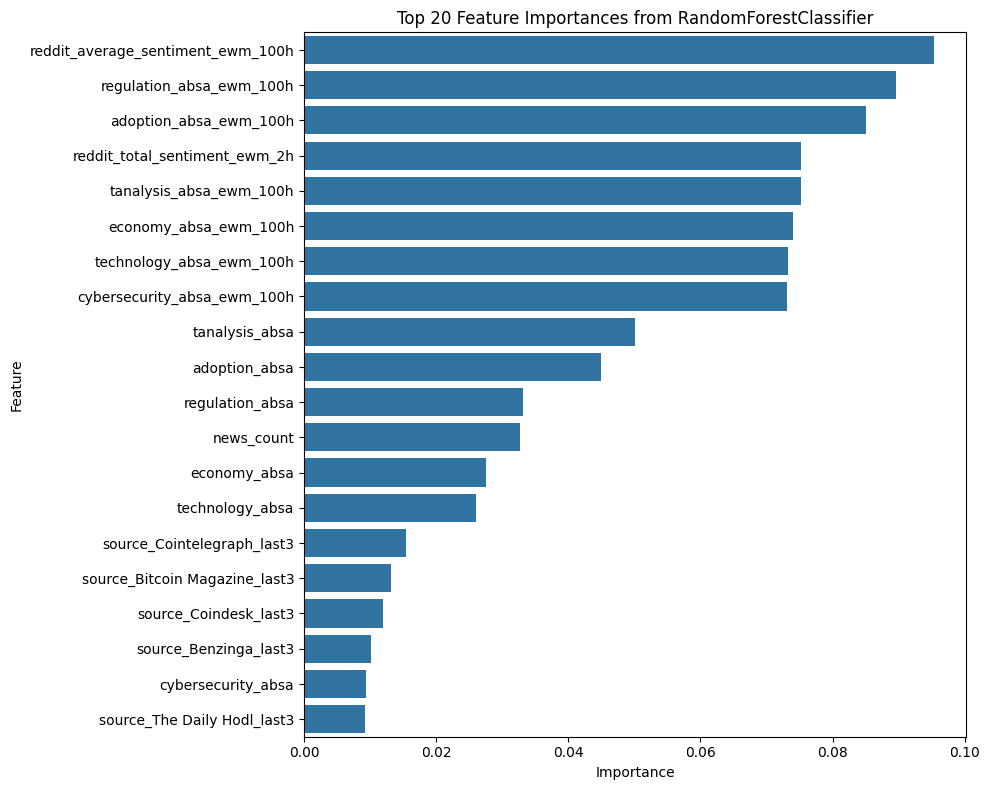

In [5]:
# Get feature importances from the best RandomForest model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from RandomForestClassifier')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.3814
ROC AUC Score (One-vs-Rest): 0.5533

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.36      0.24      0.29      2648
 Neutral (1)       0.43      0.42      0.43      3274
 Bullish (2)       0.35      0.47      0.40      2862

    accuracy                           0.38      8784
   macro avg       0.38      0.38      0.37      8784
weighted avg       0.38      0.38      0.38      8784


Confusion Matrix:
[[ 635  881 1132]
 [ 500 1378 1396]
 [ 607  918 1337]]


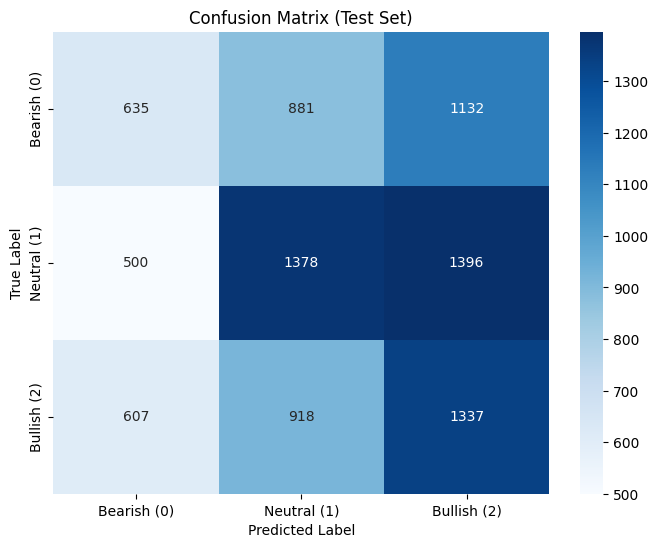

In [6]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.341398
2024-02-29    0.410920
2024-03-31    0.405914
2024-04-30    0.323611
2024-05-31    0.384409
2024-06-30    0.412500
2024-07-31    0.314516
2024-08-31    0.383065
2024-09-30    0.350000
2024-10-31    0.407258
2024-11-30    0.401389
2024-12-31    0.442204
Freq: ME, Name: correct_prediction, dtype: float64


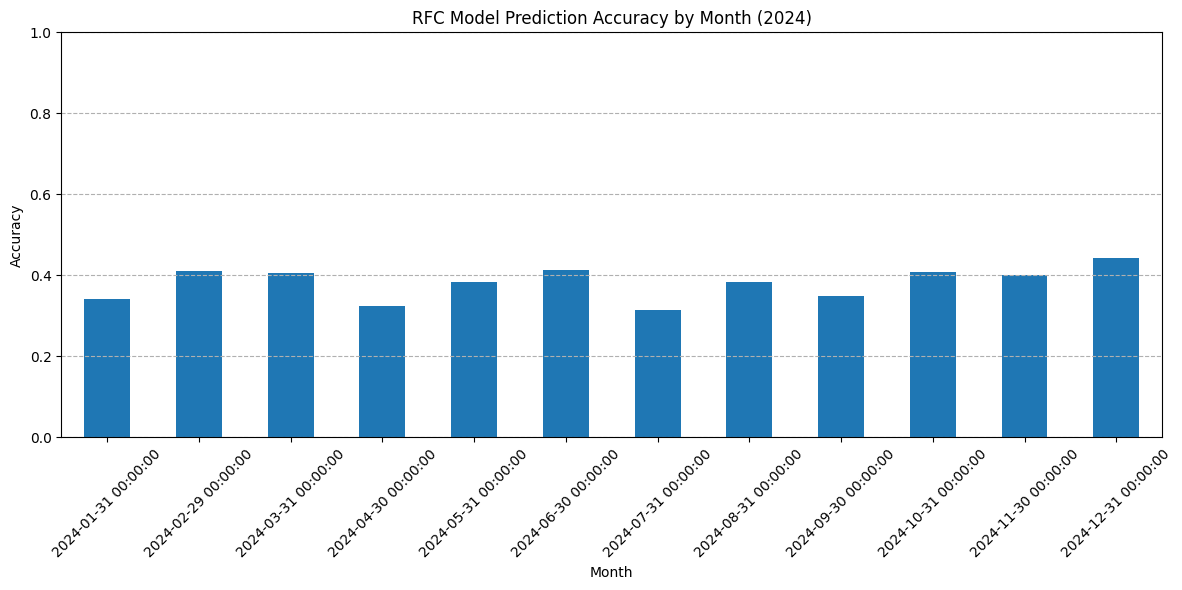


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                1      Bearish         Neutral   
2024-01-01 01:00:00       1                1      Neutral         Neutral   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                0      Neutral         Bearish   
2024-01-01 04:00:00       2                1      Bullish         Neutral   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.317300      0.409168      0.273532  
2024-01-01 01:00:00      0.301611      0.404019      0.294371  
2024-01-01 02:00:00      0.312673      0.348943      0.338384  
2024-01-01 03:00:00      0.358661      0.293105      0.348234  
2024-01-01 04:00:00      0.327430      0.353853      0.318717  


In [7]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('RFC Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy


Predicted signal distribution for backtest:
signal
 1.000000    65
 0.000000     5
-0.250000     4
 0.500000     4
-0.500000     4
             ..
 0.862221     1
 0.724442     1
 0.448883     1
-0.102234     1
 0.749866     1
Name: count, Length: 8684, dtype: int64
Overall Annual Return: 184.77%
Overall Annual Sharpe Ratio: 3.0242
Maximum Drawdown: -24.89 %
Alpha: 1.3726
Beta: 0.269

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.847661    0.368503     0.268972      0.864029       3.024162


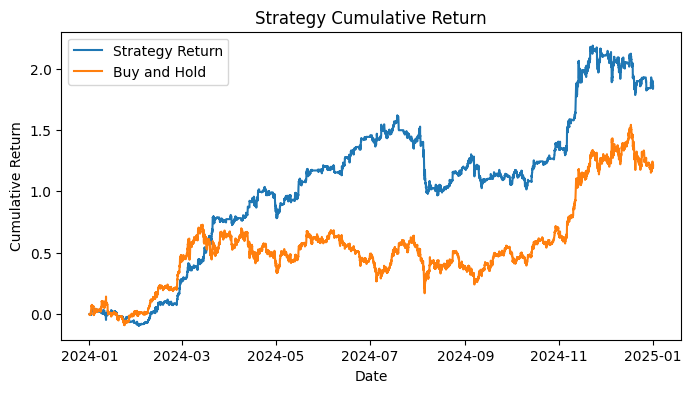

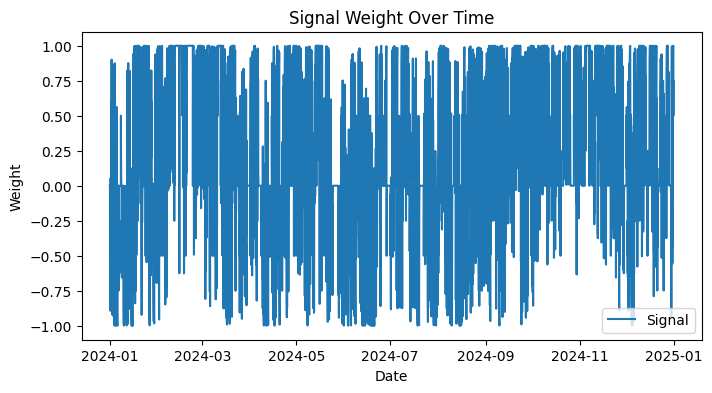

In [14]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# apply ewma to the signal column
df_backtest['signal'] = df_backtest['signal'].ewm(span=3).mean()

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())

run_backtest(df_backtest, freq='h')